# Прогнозирование оттока клиентов банка

## **Цель**:
Разработать модель машинного обучения для прогнозирования оттока клиентов банка на основе их характеристик, чтобы помочь бизнесу снизить потери и улучшить стратегии удержания клиентов.

---
## **Описание проекта**
**Построение модели прогнозирования оттока клиентов:**
   - Построение и сравнение классических моделей машинного обучения (логистическая регрессия, случайный лес, градиентный бустинг и др.).
   - Оптимизация гиперпараметров и оценка качества моделей с учетом дисбаланса классов.

Источник данных:
https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset?resource=download

---

## **Вопросы**
1. **Подготовка данных:**
   - Как кодировать категориальные признаки (country, gender)?
   - Нужно ли масштабировать числовые признаки (age, balance)?

2. **Борьба с дисбалансом:**
   - Какой метод лучше: oversampling (SMOTE), undersampling или веса классов?
   - Какие метрики (F1, ROC-AUC) использовать для оценки качества?

3. **Выбор модели:**
   - Какая модель (логистическая регрессия, случайный лес, XGBoost) дает лучший результат?
   - Как сравнить важность признаков в разных моделях?

4. **Оптимизация:**
   - Какие гиперпараметры (глубина деревьев, learning rate) улучшают качество?
   - Как использовать кросс-валидацию для оценки устойчивости модели?

5. **Оценка:**
   - Какая модель лучше работает на тестовой выборке: точность vs полнота?
   - Как интерпретировать матрицу ошибок для бизнеса?

6. **Деплоймент:**
   - Какие признаки наиболее критичны для прогноза?
   - Можно ли упростить модель без потери качества?

---
## **Описание полей таблицы**

1. **customer_id** (Идентификатор клиента)
   - Уникальный идентификатор клиента в системе банка.

2. **credit_score** (Кредитный рейтинг)
   - Числовой показатель, отражающий кредитоспособность клиента (чем выше, тем лучше).

3. **country** (Страна)
   - Страна проживания клиента (например, Германия, Франция, Испания).

4. **gender** (Пол)
   - Пол клиента (мужчина/женщина).

5. **age** (Возраст)
   - Возраст клиента в годах.

6. **tenure** (Срок сотрудничества)
   - Количество лет, в течение которых клиент пользуется услугами банка.

7. **balance** (Баланс на счете)
   - Сумма денег на счете клиента.

8. **products_number** (Количество продуктов)
   - Количество банковских продуктов, которыми пользуется клиент (например, депозит, кредит, ипотека).

9. **credit_card** (Наличие кредитной карты)
   - Бинарный признак: 1 — у клиента есть кредитная карта, 0 — нет.

10. **active_member** (Активный клиент)
    - Бинарный признак: 1 — клиент активно пользуется услугами банка, 0 — неактивен.

11. **estimated_salary** (Предполагаемая зарплата)
    - Оценка годового дохода клиента.

12. **churn** (Отток)
    - Целевая переменная: 1 — клиент ушел из банка, 0 — клиент остался.

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np

import optuna.visualization as vis
import plotly.io as pio

# Рендерер по умолчанию статический
pio.renderers.default = "png"

# Сети. Дополнительно
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Сети. Модели
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Сети. Оптимизация
import optuna
from sklearn.model_selection import StratifiedKFold
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

Чтение данных и определение функции для диагностики df:

In [2]:
# чтение
df_ml = pd.read_csv('data\\bank_customer_a.csv', sep = ',')

# определение функции
def df_diagnostics(df1, target_col=None, iqr_coefficient=1.5):
    # Собираем основные характеристики столбцов
    diag = pd.DataFrame({
        'dtypes': df1.dtypes,
        'count': df1.count(),
        'unique': df1.nunique(),
        'nan_count': df1.isnull().sum(),
        'nan_%': df1.isnull().sum() / df1.shape[0] * 100})

    # Словарь описывающий, какую функцию применить для каждой метрики
    metrics = {
        'mean': lambda s: s.mean(),
        'median': lambda s: s.median(),
        'min': lambda s: s.min(),
        '25%': lambda s: s.quantile(0.25), # 25% квартиль
        '50%': lambda s: s.quantile(0.50), # 50% квартиль (медиана)
        '75%': lambda s: s.quantile(0.75), # 75% квартиль
        'max': lambda s: s.max()}

    # Вычисляем метрики только для числовых столбцов
    numeric_cols = df1.select_dtypes(include=[np.number]).columns
    for metric, func in metrics.items():
        diag[metric] = [func(df1[col]) if col in numeric_cols else np.nan
                        for col in df1.columns]

    # Подсчёт количества выбросов с регулируемым коэффициентом IQR
    def count_outliers_iqr(col, iqr_coef=iqr_coefficient):
        if pd.api.types.is_numeric_dtype(col) and not pd.api.types.is_bool_dtype(col):
            Q1 = col.quantile(0.25)
            Q3 = col.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_coef * IQR
            upper_bound = Q3 + iqr_coef * IQR
            return ((col < lower_bound) | (col > upper_bound)).sum()
        else:
            return np.nan

    # Применяем функцию count_outliers_iqr только к числовым столбцам
    diag['outliers_count'] = [
        count_outliers_iqr(df1[col]) if pd.api.types.is_numeric_dtype(df1[col]) and not pd.api.types.is_bool_dtype(df1[col]) else np.nan
        for col in df1.columns]

    # Количество строк с пропущенными значениями в целевой переменной (если она указана)
    if target_col is not None:
        rows_with_nan_target = df1[target_col].isnull().sum()
        diag['rows_nan_target'] = [rows_with_nan_target] * len(df1.columns)

    # Добавляем корреляцию с целевой переменной (если она указана)
    if target_col is not None and pd.api.types.is_numeric_dtype(df1[target_col]):
        diag['corr_with_target'] = [df1[col].corr(df1[target_col]) if pd.api.types.is_numeric_dtype(df1[col]) else np.nan
                                      for col in df1.columns]

    # Вычисляем количество дублирующих строк в df
    duplicates_count = df1.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count,
          f"\nOutliers_count: Выбросы в данных более IQR * {iqr_coefficient}")

    # Возвращаем df с градиентной подсветкой, форматированием и округлением чисел
    return (diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)
            .format("{:.2f}", subset=diag.select_dtypes(include=[np.number]).columns))

---
# Обзор таблиц


In [3]:
df_ml.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Информация о таблицах

In [4]:
df_diagnostics(df_ml)

Количество дублирующих строк: 0 
Outliers_count: Выбросы в данных более IQR * 1.5


,dtypes,count,unique,nan_count,nan_%,mean,median,min,25%,50%,75%,max,outliers_count
customer_id,int64,10000.00,10000.00,0.00,0.00,15690940.57,15690738.00,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00,0.00
credit_score,int64,10000.00,460.00,0.00,0.00,650.53,652.00,350.00,584.00,652.00,718.00,850.00,15.00
country,object,10000.00,3.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan
gender,object,10000.00,2.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan
age,int64,10000.00,70.00,0.00,0.00,38.92,37.00,18.00,32.00,37.00,44.00,92.00,359.00
tenure,int64,10000.00,11.00,0.00,0.00,5.01,5.00,0.00,3.00,5.00,7.00,10.00,0.00
balance,float64,10000.00,6382.00,0.00,0.00,76485.89,97198.54,0.00,0.00,97198.54,127644.24,250898.09,0.00
products_number,int64,10000.00,4.00,0.00,0.00,1.53,1.00,1.00,1.00,1.00,2.00,4.00,60.00
credit_card,int64,10000.00,2.00,0.00,0.00,0.71,1.00,0.00,0.00,1.00,1.00,1.00,0.00
active_member,int64,10000.00,2.00,0.00,0.00,0.52,1.00,0.00,0.00,1.00,1.00,1.00,0.00


Анализ информации о таблице показал, что:
- клиенты банка по полю `customer_id` все уникальные
- имена полей корректные
- типы данных в полях корректны
- в каждом поле по 10 000 значений, пропусков нет
- в некоторых полях есть выбросы при расчёте по методу IQR * 1.5

Построим гистограммы распределений всех числовых полей:

---
# Подготовка данных


Определим функцию для наложения на df тепловой карты:

In [5]:
def highlight_cells(df, col_heatmap=None, cmap='RdYlGn', decimal_places=3):
    """В заданных полях в df накладываем тепловую карту"""

    # Если входной объект - Series, преобразуем его в DataFrame
    if isinstance(df, pd.Series):
        df = df.to_frame()

    # Применение стилей к DataFrame
    styled_df1 = df.style

    # К каждому указанному полю применяем тепловую карту
    for col in col_heatmap:
        styled_df1 = styled_df1.background_gradient(subset=[col], cmap=cmap,
                        vmin=df[col].min(), vmax=df[col].max())

    # Форматируем числа в столбцах с тепловой картой
    format_str = f"{{:.{decimal_places}f}}"
    styled_df1 = styled_df1.format(format_str, subset=col_heatmap)

    return styled_df1

Приступим к подготовке данных для построения модели прогнозирования:

In [6]:
# Удалим поле `customer_id`, так как оно не несёт полезной информации
df_ml.drop(columns=['customer_id'], inplace=True)

# Преобразуем с помощью `One-Hot Encoding` категориальные признаки в полях `country` и `gender`:
# После этого в df появятся новые столбцы: `country_Germany`, `country_Spain`, `gender_Male`
df_ml = pd.get_dummies(df_ml, columns=['country', 'gender'], drop_first=True)

# Масштабируем числовые признаки в полях, значения которых могут достигать больших размеров
scaler = StandardScaler()
df_ml[['credit_score', 'age', 'balance', 'estimated_salary']] = scaler.fit_transform(
        df_ml[['credit_score', 'age', 'balance', 'estimated_salary']])

# Проверим баланс классов целевой переменной
print('Баланс классов целевой переменной:')
df_ml['churn'].value_counts(normalize=True)

Баланс классов целевой переменной:


churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Разделим данные:

In [7]:
# Разделим данные на признаки (X) и целевую переменную (y):
X = df_ml.drop(columns=['churn'])
y = df_ml['churn']

# Разделим данные на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---
# Определение моделей, выдающих лучшие метрики

Далее построим связку для обучения нескольких моделей пока без подбора гиперпараметров и вывод результатов прогноза для каждой модели:

In [8]:
def train_and_predict(X_train, X_test, y_train, y_test, network):

    random_state = 42

    # Выбор модели
    if network == "Logistic Regression":
        model2 = LogisticRegression(max_iter=1000)
    elif network == "Random Forest":
        model2 = RandomForestClassifier(n_estimators=100, random_state=random_state)
    elif network == "Gradient Boosting":
        model2 = GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    elif network == "SVM (RBF Kernel)":
        model2 = SVC(kernel='rbf', probability=True, random_state=random_state)
    elif network == "K-Nearest Neighbors (KNN)":
        model2 = KNeighborsClassifier(n_neighbors=5)
    elif network == "XGBoost":
        model2 = XGBClassifier(random_state=random_state)
    elif network == "CatBoost":
        model2 = CatBoostClassifier(random_state=random_state, verbose=0,
                                    allow_writing_files=False)  # verbose=0 для отключения логов
    elif network == "AdaBoost":
        model2 = AdaBoostClassifier(random_state=random_state)
    elif network == "Extra Trees":
        model2 = ExtraTreesClassifier(random_state=random_state)
    elif network == "Multi-layer Perceptron (MLP)":
        model2 = MLPClassifier(random_state=random_state, max_iter=1000)
    elif network == "Gaussian Naive Bayes":
        model2 = GaussianNB()
    elif network == "Decision Tree":
        model2 = DecisionTreeClassifier(random_state=random_state)
    else:
        raise ValueError("Неверный тип модели. Допустимые значения: 1-15.")

    # Обучаем модель
    model2.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_val_pred = model2.predict(X_test)
    y_val_probs = model2.predict_proba(X_test)[:, 1]

    # Вычисляем метрики
    accuracy = round(accuracy_score(y_test, y_val_pred), 3)
    f1score = round(f1_score(y_test, y_val_pred), 3)
    auc = round(roc_auc_score(y_test, y_val_probs), 3)

    return accuracy, f1score, auc

Запустим для каждой модели обучение и прогноз. Выведем таблицу метрик моделей:

In [9]:
# Модели машинного обучения
neural_network = {1: "Logistic Regression", 2: "Random Forest", 3: "Gradient Boosting", 4: "SVM (RBF Kernel)",
                  5: "K-Nearest Neighbors (KNN)", 6: "XGBoost", 7: "CatBoost", 8: "AdaBoost", 9: "Extra Trees",
                  10: "Multi-layer Perceptron (MLP)", 11: "Gaussian Naive Bayes", 12: "Decision Tree"}

# перебор сетей по очереди
network_set = [neural_network[key] for key in range(1, 13)]

# Создаем пустой DataFrame для аккумуляции данных статистики
df_enumeration = pd.DataFrame(index=network_set, columns=['Accuracy', 'F1_score', 'AUC'])

for network_name in network_set:
    # вызов функции с выполнением прогноза
    accuracy, f1score, auc = train_and_predict(X_train, X_test, y_train, y_test, network=network_name)

    # сохраняем в таблицу замер качества прогноза
    df_enumeration.loc[network_name, ['Accuracy', 'F1_score', 'AUC']] = accuracy, f1score, auc

# Для наглядности накладываем на каждое поле df отдельную тепловую карту
styled_df = highlight_cells(df_enumeration, ['Accuracy', 'F1_score', 'AUC'])

styled_df

,Accuracy,F1_score,AUC
Logistic Regression,0.808,0.284,0.775
Random Forest,0.865,0.583,0.852
Gradient Boosting,0.870,0.605,0.871
SVM (RBF Kernel),0.822,0.243,0.839
K-Nearest Neighbors (KNN),0.832,0.465,0.760
XGBoost,0.849,0.565,0.833
CatBoost,0.870,0.606,0.862
AdaBoost,0.860,0.568,0.848
Extra Trees,0.859,0.562,0.846
Multi-layer Perceptron (MLP),0.864,0.596,0.860



**Лучшие модели:**
- **CatBoost** (`Accuracy=0.87`, `F1=0.606`, `AUC=0.862`).
- **Gradient Boosting** (`Accuracy=0.87`, `F1=0.605`, `AUC=0.871`).

**Почему они лучшие?**
- Высокие значения **всех трёх метрик**, что указывает на сбалансированность модели.
- **F1-score > 0.6** — это сильный показатель для задач с дисбалансом классов (предполагается, что данные несбалансированы, так как Accuracy высокий, а F1 низкий у других моделей).
- **AUC > 0.85** — модель хорошо разделяет классы.

---
# Тонкая настройка моделей

## Модель CatBoost

In [16]:
def cross_validate_model_catb(trial, params, X_train, y_train):
    # кросс-валидация
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostClassifier(allow_writing_files=False, # отключаем создание файлов
                                   **params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=20,
                 use_best_model=True, verbose=False)

        y_pred1 = model.predict(X_val)
        fold_f1 = f1_score(y_val, y_pred1, average='binary')
        f1_scores.append(fold_f1)

        # Отправляем промежуточный результат
        current_mean = np.mean(f1_scores)
        trial.report(current_mean, step=fold_idx)

        # Проверяем необходимость прерывания
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return np.mean(f1_scores)

def objective_catb(trial):
    search_params = {  # Параметры для подбора
        'iterations': trial.suggest_int('iterations', 1000, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 2e-1, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 5),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-1, 0.4, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.0),
        'border_count': trial.suggest_int('border_count', 150, 254),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 140, 180),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced',]),
    }

    fixed_params = {  # Фиксированные параметры
        # параметр метрики
        'eval_metric': 'F1',
        # критерии для ранней остановки
        'od_type': 'Iter',
        'od_wait': 20,

        'bootstrap_type': 'Bayesian',
        'sampling_frequency': 'PerTreeLevel',
        'verbose': False}

    # Объединение параметров
    params = {**search_params, **fixed_params}

    # Вызов кросс-валидации с передачей trial
    return cross_validate_model_catb(trial, params, X_train, y_train)

# отключение логирования в вывод
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Настройка исследования
study_catb = optuna.create_study(direction='maximize', load_if_exists=True,
                                 sampler=TPESampler(seed=42, n_startup_trials=20),
                                 # 3 фолдов перед проверкой и 5 trials для расчёта медианы
                                 pruner=MedianPruner(n_warmup_steps=3, n_min_trials=5),
                                 storage="sqlite:///optuna_studies/my_study.db",
                                 study_name="CatBoost_05042025_3")

# optuna-dashboard sqlite:///bank_customer_predict/optuna_studies/my_study.db

study_catb.optimize(objective_catb, n_trials=2000, show_progress_bar=True)

# Дополнение к выводу результатов
print(f'Всего trials: {len(study_catb.trials)}')
print(f'Прерванных trials: {len([t for t in study_catb.trials if t.state == optuna.trial.TrialState.PRUNED])}\n')

# Выводим результаты лучшего trial
print('Лучший trial:')
best_trial = study_catb.best_trial
print(f'  F1-score: {best_trial.value:.4f}')
print('  Параметры:')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

  0%|          | 0/2000 [00:00<?, ?it/s]

Всего trials: 2000
Прерванных trials: 23

Лучший trial:
  F1-score: 0.6272
  Параметры:
    iterations: 1246
    learning_rate: 0.24542288856938382
    depth: 4
    l2_leaf_reg: 7.4193859108392
    random_strength: 0.21417633621188778
    bagging_temperature: 0.7149199622795057
    border_count: 250
    grow_policy: SymmetricTree
    min_data_in_leaf: 171
    auto_class_weights: Balanced


---
`1 исследование:`

`Результаты:` F1-score: 0.6187873626771246

`Параметры подобранные:` = iterations: 1629, learning_rate: 0.23594916342340075, depth: 6, l2_leaf_reg: 12.37221802451466, random_strength: 0.4351987298552858, bagging_temperature: 1.1467877895618392, border_count: 199, grow_policy: Depthwise, min_data_in_leaf: 164, auto_class_weights: Balanced

`Примечания:`
- 200 испытаний для определения более узких пространств параметров, в которых продолжить испытания
- С помощью Optuna Dashboard определяем более узкие пространства параметров и запускаем второе исследование

---
`2 исследование:`

`Результаты:` F1-score: 0.6272224824342236

`Параметры подобранные:` = iterations: 1246, learning_rate: 0.24542288856938382, depth: 4, l2_leaf_reg: 7.4193859108392, random_strength: 0.21417633621188778, bagging_temperature: 0.7149199622795057, border_count: 250, grow_policy: SymmetricTree, min_data_in_leaf: 171, auto_class_weights: Balanced

`Примечания:` 2000 испытаниями для более тонкой подборки параметров

---
Оценка метрик модели CatBoost с лучшими подобранными параметрами на тестовой выборке:

In [17]:
# Получаем лучшие параметры из исследования
best_params = study_catb.best_trial.params

# Создаем и обучаем модель с лучшими параметрами
model = CatBoostClassifier(
    allow_writing_files=False,
    # Не забыть передавать фиксированные аргументы!
    **best_params)
model.fit(X_train, y_train, verbose=False)

# Делаем предсказания
y_pred = model.predict(X_test)

# Вычисляем метрики
metrics = {'Accuracy': round(accuracy_score(y_test, y_pred), 3),
           'F1_score': round(f1_score(y_test, y_pred), 3),
           'AUC': round(roc_auc_score(y_test, y_pred), 3)}

# Выводим результаты
print('Метрики модели:', metrics)

Метрики модели: {'Accuracy': 0.82, 'F1_score': 0.58, 'AUC': 0.742}


`Вывод:` До оптимизации на тестовых данных модель показала метрики Accuracy 0.87, F1_score 0.606 и AUC 0.862. С учётом того, что подбор параметров производился с применением cтратифицированной кросс-валидации с целью минимизировать переобучение, мы видим на выходе хорошие метрики. Можно конечно и дальше производить подбор с возможным незначительным улучшением метрик, если это оправдано.

---
Покажем ряд графиков по результатам оптимизации гиперпараметров

График истории оптимизации:

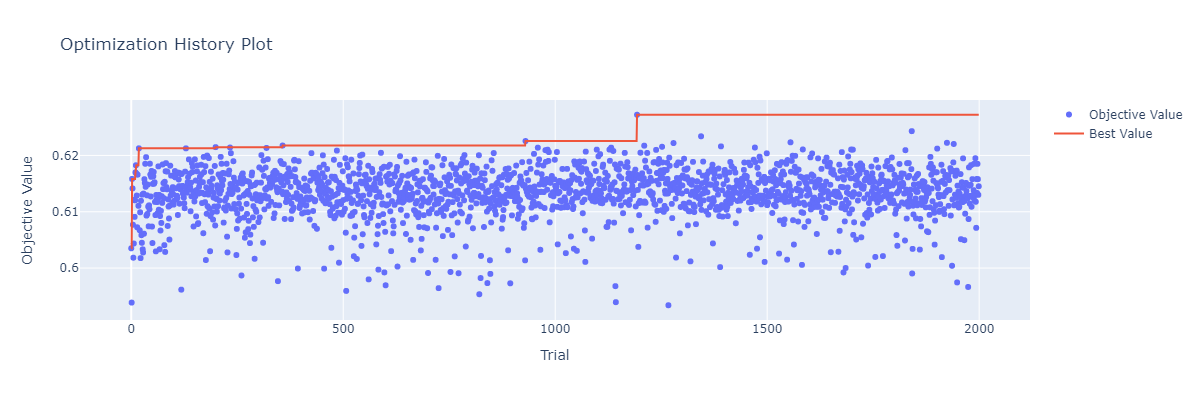

In [18]:
from optuna.visualization import plot_optimization_history

# Определим список параметров из всех для визуализации:
params_visual = ['iterations','learning_rate','depth','l2_leaf_reg']

fig = plot_optimization_history(study_catb)
fig.update_layout(width=1200, height=400)
fig.show()

График промежуточных значений:

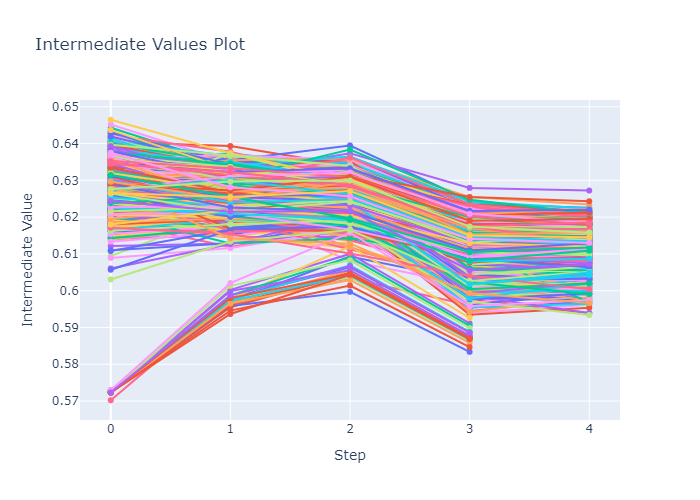

In [19]:
from optuna.visualization import plot_intermediate_values
fig = plot_intermediate_values(study_catb)
fig.show()

График оптимальных диапазонов для параметров:

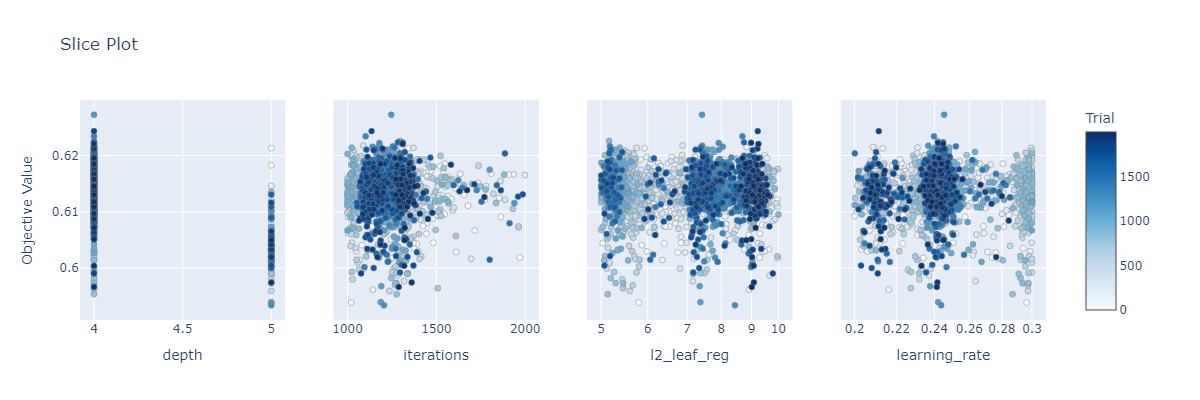

In [20]:
fig = vis.plot_slice(study_catb, params=params_visual)
fig.update_layout(width=1200, height=400)
fig.show()

График параллельных координат:

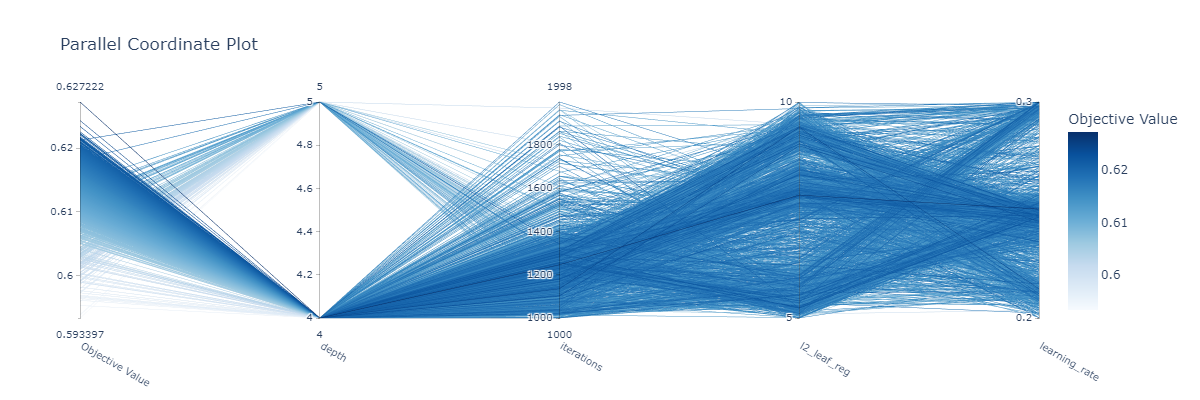

In [21]:
# Для всех параметров
fig = vis.plot_parallel_coordinate(study_catb, params=params_visual)
fig.update_layout(width=1200, height=400)
fig.show()

---
## Модель Gradient Boosting

---
Далее:
- вторую перспективную модель подгоним с помощью Optuna?
- далее вставить команды для полной подготовки модели к продакшен. Пайплайн и т.д?

---
Сверить, чтобы в двух проектах:
- вернутся к первой части с аналитическим исследованием и: 1) в исследовании текст метки и выводы править под данные 2) написать итоговый вывод 3) проверить в целом проект
- проекты корректно разделены на разделы и синхронизированы с вопросами проектов
- выводы на местах и в конце обновлены
- в проектах есть описание и содержание с ссылками